## Imports

In [2]:
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from utils import market_values, market_values_by_time_index, nodal_balance, carrier_colors

In [3]:
# dict(sorted(carrier_colors.items()))
# "aquamarine" in carrier_colors.values()

In [4]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Case Study

In [5]:
# example of bus and snapshot
bus = "DE0 1" # "AL0 0" # "DE0 1"
snap = "2013-01-01 09:00:00"
# energy carrier at bus
n.buses.carrier[bus]

'AC'

In [6]:
# active power at bus (positive if net generation at bus) in MW
n.buses_t.p.loc[snap,bus]

-1954.668418477922

In [7]:
# Lines (what reaches bus?)
# 1. sum of power @ lines with bus as bus0 and p0 (Active power at bus0 (positive if branch is withdrawing power from bus0)
n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1)
# 2. sum of power @ lines with bus as bus1 and p1 (Active power at bus1 (positive if branch is withdrawing power from bus1)
n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
# sum (if negative power is feed into bus)
lines = n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1) + n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
# sum should be the same value as the active power at the bus
lines[snap]

-1954.6684185022177

### Loads

In [8]:
# active power at bus (positive if net load) in MW
load = n.loads_t.p.loc[snap,bus]

### Generators

In [9]:
# generation of generators directly connected to bus
gens_index_direct = n.generators[n.generators.bus == bus].bus.index
# active power at bus (positive if net generation)
gen = n.generators_t.p.loc[snap, gens_index_direct].sum()

### Links

In [10]:
# links connected to the bus (bus0 of link)
links_index_direct = n.links[n.links.bus0 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p0.loc[snap, links_index_direct]#.sum()

Link
DE0 1 H2 Electrolysis                   439.525110
DE0 1 battery charger                    80.833306
DE0 1 electricity distribution grid    3293.548085
Name: 2013-01-01 09:00:00, dtype: float64

In [11]:
# links connected to the bus (bus1 of link)
links_index_direct = n.links[n.links.bus1 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p1.loc[snap, links_index_direct]#.sum()

Link
DE0 1 OCGT                                   -0.001216
DE0 1 H2 Fuel Cell                           -0.004148
DE0 1 battery discharger                     -0.117554
DE0 1 urban central gas CHP                  -0.002068
DE0 1 urban central gas CHP CC               -0.004359
DE0 1 urban central solid biomass CHP        -0.002846
DE0 1 urban central solid biomass CHP CC   -279.825313
Name: 2013-01-01 09:00:00, dtype: float64

In [12]:
# links connected to the bus (bus2 of link)
links_index_direct = n.links[n.links.bus2 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p2.loc[snap, links_index_direct]

Link
DE0 1 services urban decentral DAC    0.001763
DE0 1 urban central DAC               0.001845
Name: 2013-01-01 09:00:00, dtype: float64

In [13]:
# links connected to the bus (bus3 of link)
links_index_direct = n.links[n.links.bus3 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p3.loc[snap, links_index_direct]

Series([], Name: 2013-01-01 09:00:00, dtype: float64)

In [14]:
# links connected to the bus (bus4 of link)
links_index_direct = n.links[n.links.bus4 == bus].index
# Active power at bus1 (positive if branch is withdrawing power from bus0).
n.links_t.p4.loc[snap, links_index_direct]

Series([], Name: 2013-01-01 09:00:00, dtype: float64)

In [15]:
# Overall balance from links
links_balance = 0

for i in range(0,5):
    links_index_direct = n.links[n.links[f"bus{i}"] == bus].index
    # Active power at busi (positive if branch is withdrawing power from busi).
    links_balance += n.links_t[f"p{i}"].loc[snap, links_index_direct].sum()

links_balance

3533.952605577093

### Storage Units

In [16]:
# storage units
storage_index = n.storage_units[n.storage_units.bus == bus].index
# active power at bus (positive if net generation) in MW
su = n.storage_units_t.p.loc[snap, storage_index].sum()

### Stores

In [17]:
# stores
stores_index = n.stores[n.stores.bus == bus].index
# active power at bus (positive if net generation) in MW
st = n.stores_t.p.loc[snap, stores_index].sum()

### Overall aggregation

In [18]:
print(f"{gen} - {load} - {links_balance} + {su} + {st}")
gen - load - links_balance + su + st

1600.6981551887127 - 710.5694441264126 - 3533.952605577093 + -21.413968089540834 + 0.0


-2665.2378626043337

In [19]:
print(f"{gen} - {links_balance} + {su} + {st}")
gen  - links_balance + su + st

1600.6981551887127 - 3533.952605577093 + -21.413968089540834 + 0.0


-1954.668418477921

In [20]:
# active power at bus (positive if net generation at bus) in MW
n.buses_t.p.loc[snap, bus]

-1954.668418477922

Notes:
- shunt_impedances and transformers are not existent in network
- if you exclude the load in the balance, the bus is balanced. Why?

## Nodal Balance
- calculating import or export excess

### AC plot

In [21]:

carrier = ["AC"]
period = "2013-05"
nb_ac = nodal_balance(n, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW and unstack
nb_ac = nb_ac.unstack(level=[1]) / 1000
nb_ac.head(3)

carrier,AC,DAC,DC,H2 Electrolysis,H2 Fuel Cell,PHS,battery charger,battery discharger,electricity distribution grid,hydro,offwind-ac,offwind-dc,onwind,ror,solar,urban central gas CHP,urban central gas CHP CC,urban central solid biomass CHP CC
snapshot,,,,,,,,,,,,,,,,,,
2013-05-01 00:00:00,1.728040e-14,-4.846786,1.364242e-15,-709.514501,NaN,4.023339,-0.997366,222.558061,-1294.683850,129.764978,51.882410,130.981537,1390.354096,77.870746,NaN,NaN,NaN,2.601915
2013-05-01 03:00:00,7.275958e-15,-4.846752,-2.273737e-16,-671.842886,NaN,7.678835,-0.124167,200.931540,-1341.973201,140.630248,42.350148,123.941002,1327.052498,77.937186,85.854984,NaN,NaN,12.405591
2013-05-01 06:00:00,5.456968e-15,-4.846783,2.273737e-16,-1932.708992,NaN,-66.944392,-231.662255,0.682652,-1542.953089,33.106128,33.039351,109.680927,1046.064823,77.256034,2479.263677,NaN,NaN,0.005410


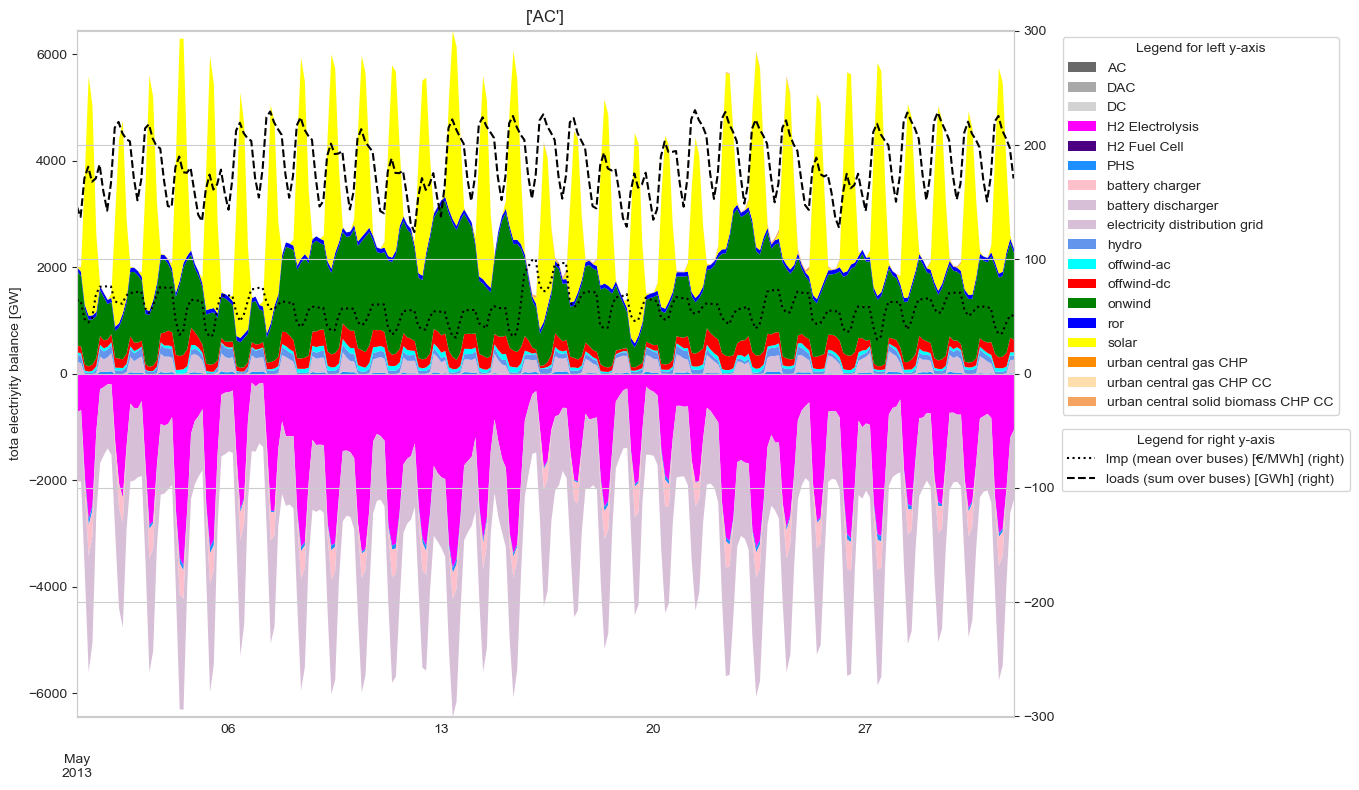

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))

df = nb_ac

# split into df with positive and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values so that they are not shown and plot negative values
ax = df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style=":", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
# set limits of secondary y-axis
ax2.set_ylim([ - 3 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 3 * lmps.max()])

# plot loads
# n.load_t.p_set (gesetzte energie nachfrage)
loads = n.loads_t.p[n.buses[n.buses.carrier.isin(carrier)].index].sum(axis=1)[period] / 1000
loads.plot(style="--", color="black", label="loads (sum over buses) [GWh]", secondary_y=True)

# rescale the y-axis
ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.2, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper center", bbox_to_anchor=(1.205, 0.43))
ax.set_ylabel("tota electriyity balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

# februrar; GAS CHP
# electricity, induytry electricity aus negativem Teil rausnehmen und als load auf positive Teil plotten

### Electricity plot

In [23]:
carrier = ["AC", "battery", "Li ion", "low voltage", "home battery"]
nb_el = nodal_balance(n, carrier = carrier, time="2013-05", aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW
nb_el = nb_el.unstack(level=[1]) / 1000
nb_el.head()

carrier,AC,BEV charger,DAC,DC,H2 Electrolysis,H2 Fuel Cell,Li ion,PHS,V2G,agriculture electricity,...,services rural resistive heater,services urban decentral air heat pump,services urban decentral resistive heater,solar,solar rooftop,urban central air heat pump,urban central gas CHP,urban central gas CHP CC,urban central resistive heater,urban central solid biomass CHP CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01 00:00:00,1.728040e-14,-5.588481,-4.846786,1.364242e-15,-709.514501,NaN,29.005386,4.023339,-3.327029,-15.363392,...,-0.030702,-25.705127,-0.416672,NaN,NaN,-90.556552,NaN,NaN,-0.602949,2.601915
2013-05-01 03:00:00,7.275958e-15,-5.073187,-4.846752,-2.273737e-16,-671.842886,NaN,180.048224,7.678835,-2.333607,-15.363392,...,-0.579590,-33.211055,-1.930783,85.854984,9.973257,-115.387525,NaN,NaN,-2.954080,12.405591
2013-05-01 06:00:00,5.456968e-15,-35.220461,-4.846783,2.273737e-16,-1932.708992,NaN,98.724230,-66.944392,-0.780729,-15.363392,...,-1.004292,-29.251562,-1.344826,2479.263677,243.879720,-128.018142,NaN,NaN,-22.536103,0.005410
2013-05-01 09:00:00,-1.455192e-14,-116.983802,-4.846792,0.000000e+00,-2727.122164,NaN,-690.246583,-113.215714,-0.112778,-15.363392,...,-0.811179,-23.824914,-0.785737,4501.546951,435.987510,-122.440003,NaN,NaN,-19.747392,0.015149
2013-05-01 12:00:00,3.637979e-15,-95.164629,-4.846303,4.547474e-16,-2465.729728,NaN,-440.791326,-88.912298,-0.113294,-15.363392,...,-0.777185,-21.992531,-0.726098,3939.859945,360.295190,-133.092573,NaN,NaN,-18.045108,0.005385


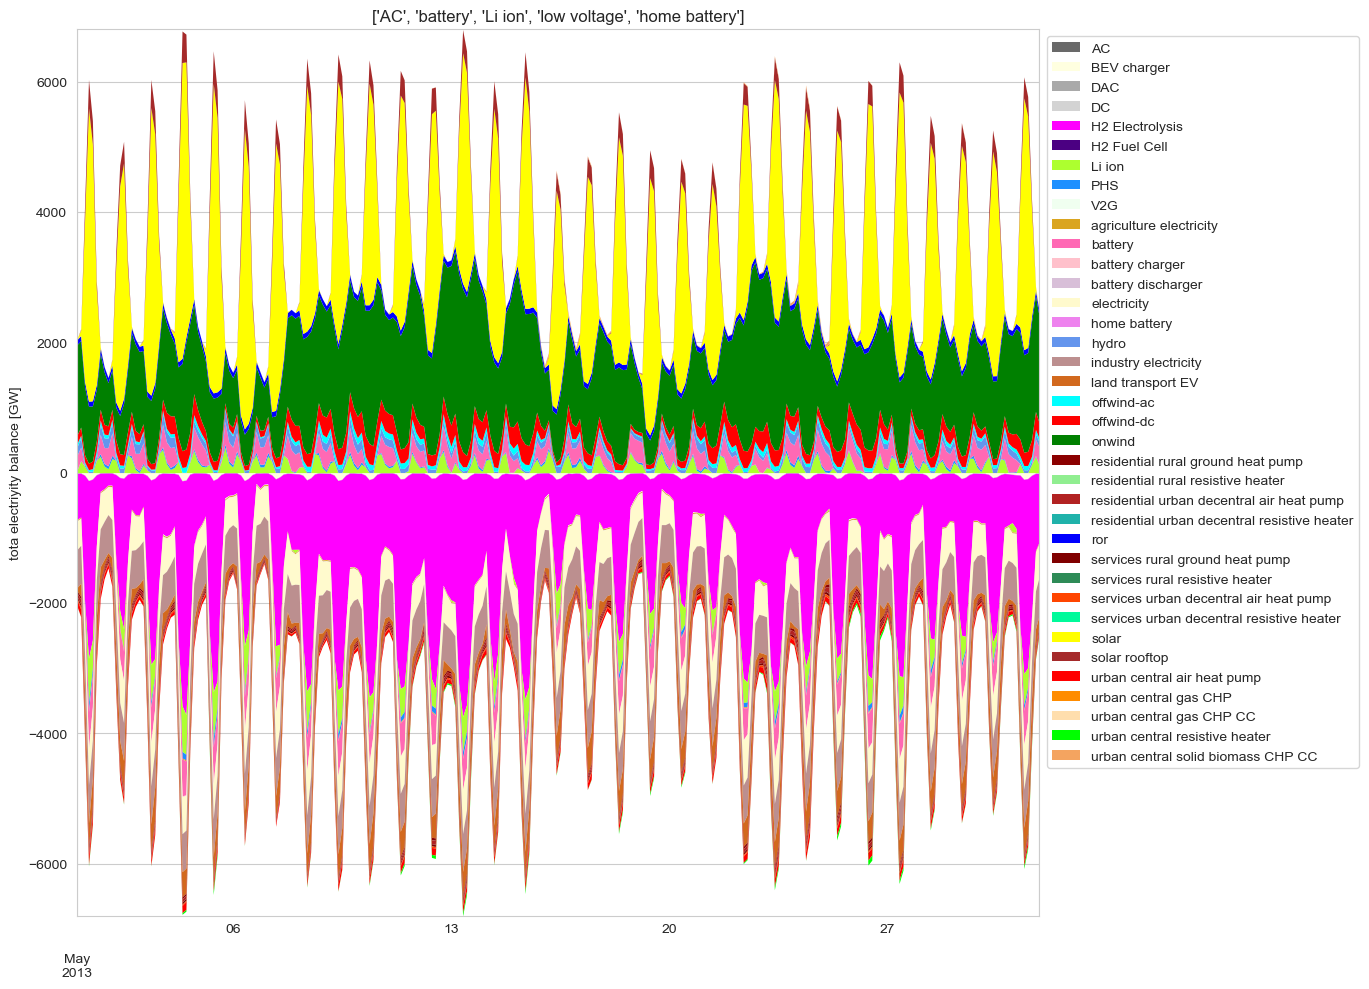

In [24]:
fig, ax = plt.subplots(figsize=(14, 10))

df = nb_el

# split into df with posititve and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename
df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# rescale the y axis

ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.17, 1))
ax.set_ylabel("tota electriyity balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

### H2 plot

In [41]:
carrier = ["H2"] # ["H2", "H2 liquid"]
nb_h2 = nodal_balance(n, carrier, time="2013-05", aggregate=['component', 'bus'], energy=True)   # in units of energy
# convert from MW to GW
nb_h2 = nb_h2.unstack(level=[1]) / 1000
nb_h2.head()

carrier,Fischer-Tropsch,H2,H2 Electrolysis,H2 Fuel Cell,H2 for industry,H2 liquefaction,SMR,SMR CC,Sabatier,land transport fuel cell
snapshot,,,,,,,,,,
2013-05-01 00:00:00,-542.146797,517.121510,482.467203,NaN,-67.041096,-172.206968,NaN,46.718679,-246.682337,-18.225472
2013-05-01 03:00:00,-557.643571,672.094728,456.850203,NaN,-67.041096,-172.206968,NaN,43.267207,-262.684842,-112.631268
2013-05-01 06:00:00,-553.662805,-58.846250,1314.241412,NaN,-67.041096,-172.206968,NaN,3.559791,-327.835909,-138.199076
2013-05-01 09:00:00,-553.189267,-621.166583,1854.443071,NaN,-67.041096,-172.206968,NaN,3.211988,-314.882747,-129.158754
2013-05-01 12:00:00,-542.673898,-487.753732,1676.695968,NaN,-67.041096,-172.206968,NaN,3.533832,-253.137827,-157.406655


In [42]:
# get carriers that are present
nb_h2.columns

Index(['Fischer-Tropsch', 'H2', 'H2 Electrolysis', 'H2 Fuel Cell',
       'H2 for industry', 'H2 liquefaction', 'SMR', 'SMR CC', 'Sabatier',
       'land transport fuel cell'],
      dtype='object', name='carrier')

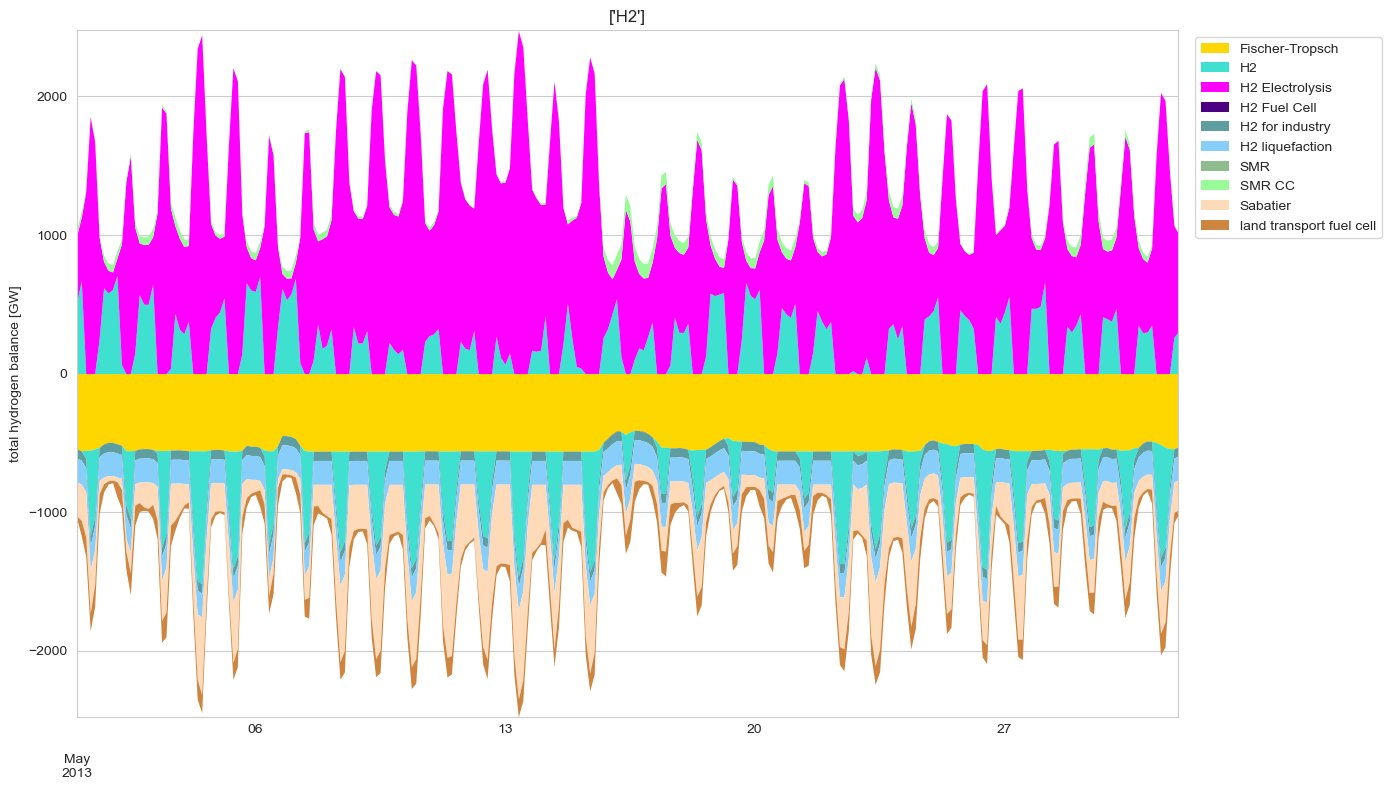

In [43]:
fig, ax = plt.subplots(figsize=(14, 8))

df = nb_h2

# split into df with posititve and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename
df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# rescale the y axis
ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.1, 1))
ax.set_ylabel("total hydrogen balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

### Heat plot

In [28]:
nb_heat = nodal_balance(n, ["residential rural heat", "services rural heat", "residential urban decentral heat", "services urban decentral heat", "urban central heat"], time="2013-05", aggregate=['component', 'bus'], energy=True)   # in units of energy
# convert from MW to GW
nb_heat = nb_heat.unstack(level=[1]) / 1000
nb_heat.head()

carrier,DAC,Fischer-Tropsch,H2 Fuel Cell,agriculture heat,low-temperature heat for industry,residential rural gas boiler,residential rural ground heat pump,residential rural heat,residential rural resistive heater,residential rural water tanks charger,...,urban central air heat pump,urban central gas CHP,urban central gas CHP CC,urban central gas boiler,urban central heat,urban central resistive heater,urban central solar thermal,urban central solid biomass CHP CC,urban central water tanks charger,urban central water tanks discharger
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01 00:00:00,-18.562923,135.534426,NaN,-64.882732,-17.818493,NaN,89.132940,-89.125186,NaN,-0.014989,...,217.822909,NaN,NaN,NaN,-319.516263,0.596919,NaN,7.325812,-83.191433,77.790836
2013-05-01 03:00:00,-18.562791,139.408617,NaN,-64.882732,-17.818493,NaN,128.259811,-128.563161,0.306779,-0.014750,...,273.691126,NaN,NaN,NaN,-452.587034,2.924539,NaN,34.927603,-55.556312,93.557764
2013-05-01 06:00:00,-18.562913,138.413423,NaN,-64.882732,-17.818493,NaN,122.846886,-123.222928,0.989181,-2.072228,...,326.134840,NaN,NaN,NaN,-428.719070,22.310443,11.244762,0.017247,-92.966666,59.918789
2013-05-01 09:00:00,-18.562950,138.295039,NaN,-64.882732,-17.818493,NaN,115.167417,-115.544828,0.796600,-1.445473,...,343.189262,NaN,NaN,NaN,-394.778986,19.549918,79.422404,0.044356,-191.791778,42.415352
2013-05-01 12:00:00,-18.561074,135.666197,NaN,-64.882732,-17.818493,NaN,115.377265,-115.686964,0.771581,-1.577371,...,391.641556,NaN,NaN,NaN,-390.956168,17.864657,78.231161,0.016445,-237.822527,41.702373


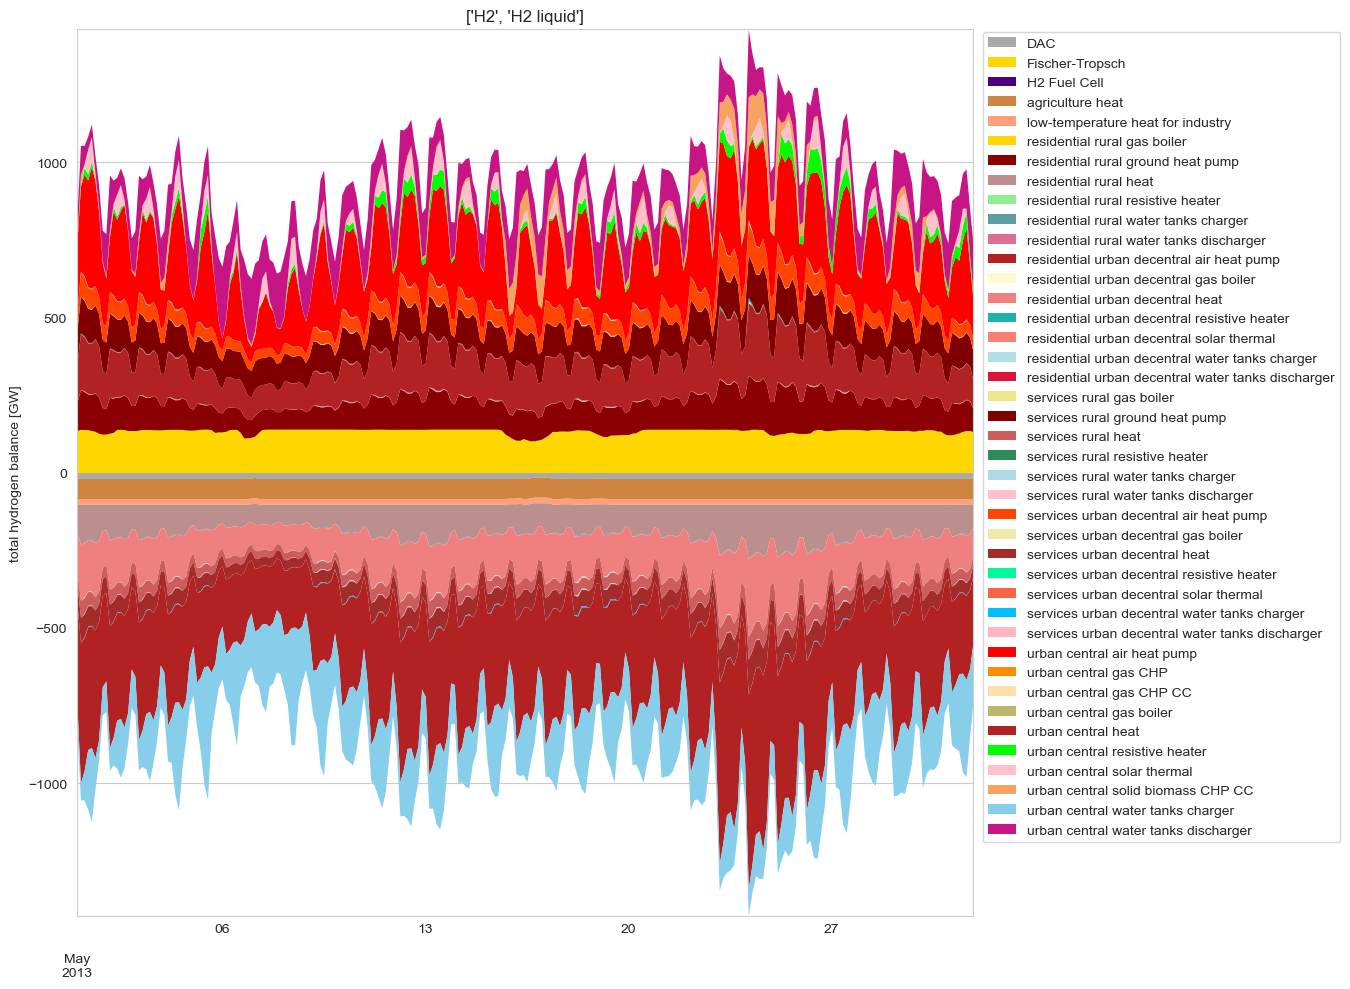

In [29]:
fig, ax = plt.subplots(figsize=(14, 10))

df = nb_heat

# split into df with posititve and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename
df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# rescale the y axis

ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.21, 1.005))
ax.set_ylabel("total hydrogen balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

In [30]:
carrier = ["urban central heat"]
nb_ucheat = nodal_balance(n, carrier=carrier, time="2013-05", aggregate=['component', 'bus'], energy=True)   # in units of energy
# convert from MW to GW
nb_ucheat = nb_ucheat.unstack(level=[1]) / 1000
nb_ucheat.head()

carrier,DAC,Fischer-Tropsch,H2 Fuel Cell,low-temperature heat for industry,urban central air heat pump,urban central gas CHP,urban central gas CHP CC,urban central gas boiler,urban central heat,urban central resistive heater,urban central solar thermal,urban central solid biomass CHP CC,urban central water tanks charger,urban central water tanks discharger
snapshot,,,,,,,,,,,,,,
2013-05-01 00:00:00,-18.561073,135.534426,NaN,-17.818493,217.822909,NaN,NaN,NaN,-319.516263,0.596919,NaN,7.325812,-83.191433,77.790836
2013-05-01 03:00:00,-18.561071,139.408617,NaN,-17.818493,273.691126,NaN,NaN,NaN,-452.587034,2.924539,NaN,34.927603,-55.556312,93.557764
2013-05-01 06:00:00,-18.561073,138.413423,NaN,-17.818493,326.134840,NaN,NaN,NaN,-428.719070,22.310443,11.244762,0.017247,-92.966666,59.918789
2013-05-01 09:00:00,-18.561073,138.295039,NaN,-17.818493,343.189262,NaN,NaN,NaN,-394.778986,19.549918,79.422404,0.044356,-191.791778,42.415352
2013-05-01 12:00:00,-18.559269,135.666197,NaN,-17.818493,391.641556,NaN,NaN,NaN,-390.956168,17.864657,78.231161,0.016445,-237.822527,41.702373


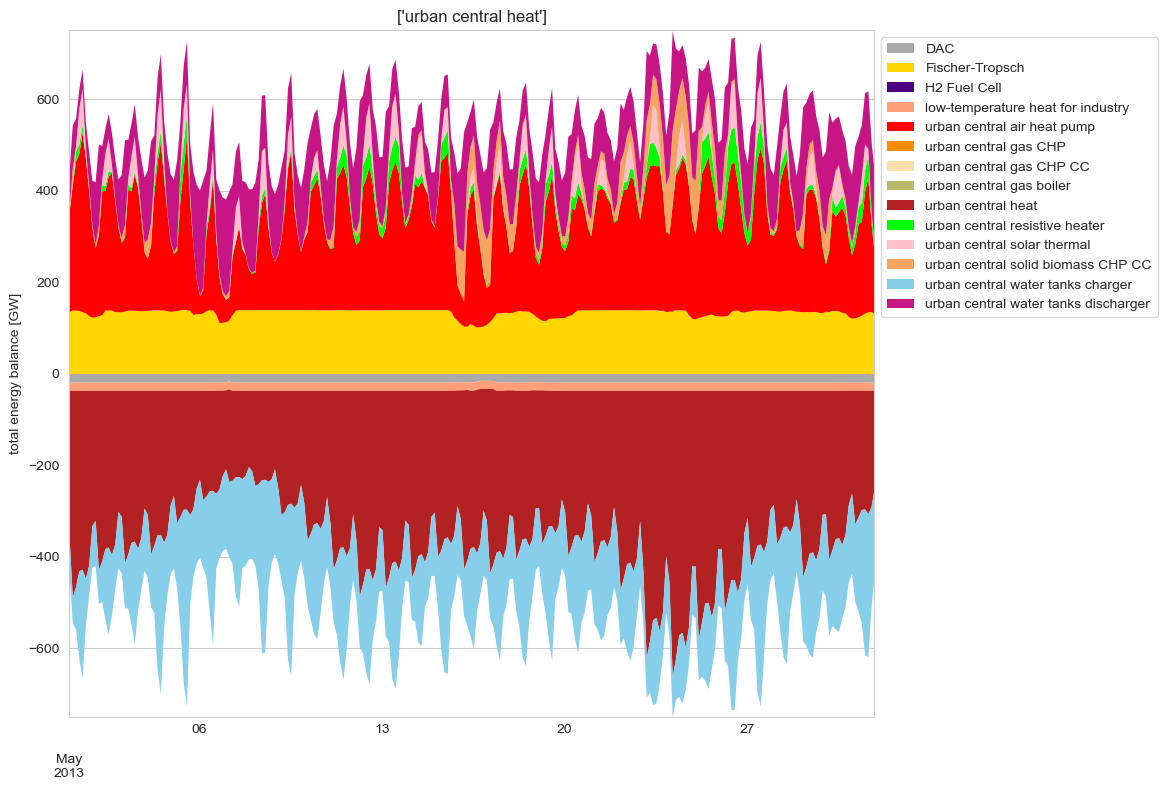

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))

df = nb_ucheat

# split into df with posititve and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename
df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# rescale the y axis

ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.18, 1))
ax.set_ylabel("total energy balance [GW]")
ax.set_xlabel("")
ax.set_title(f"{carrier}")
fig.tight_layout()

## LMP Determination

In [32]:
# find snap with easy determination of marginal generator
n.generators_t.p

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,AT0 1 onwind,AT0 1 ror,AT0 1 solar,AT0 2 onwind,...,RS0 1 solar rooftop,SE3 0 solar rooftop,SE3 1 solar rooftop,SE3 2 solar rooftop,SE3 3 solar rooftop,SE3 5 solar rooftop,SE3 6 solar rooftop,SE3 7 solar rooftop,SI0 0 solar rooftop,SK0 0 solar rooftop
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,4917.113011,444.933907,0.000000,0.000160,102.555845,0.000000,0.000317,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,4623.535568,444.620944,0.000000,0.000105,102.483658,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,4795.128080,3455.948969,444.467881,792.324661,0.000061,102.448376,1207.124091,0.000000,...,365.072843,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,352.259879,523.284014
2013-01-01 09:00:00,0.000000,0.000000,11509.646090,1471.522842,444.478772,2989.259557,0.000000,102.450821,5691.630927,0.000000,...,1074.839751,1.210543,0.0,0.000619,0.035075,0.0,2.337271,0.0,1407.871519,1858.687944
2013-01-01 12:00:00,0.000000,0.000000,6377.253396,497.291894,447.815959,1678.141986,0.000000,103.219830,4162.664607,0.000000,...,577.275672,0.269088,0.0,0.000000,0.017729,0.0,0.533430,0.0,862.907142,875.497826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,4911.200758,448.489909,549.709582,1048.040739,0.000000,126.698785,4358.484623,0.000000,...,944.298303,0.260902,0.0,0.000000,0.150806,0.0,0.258412,0.0,130.935906,886.166876
2013-12-31 12:00:00,0.000000,0.000000,2989.734046,1290.876086,548.017655,710.217489,0.000000,126.316122,2908.464725,0.000000,...,407.896036,0.000000,0.0,0.000000,0.047555,0.0,0.000000,0.0,113.992430,544.052274
2013-12-31 15:00:00,0.000000,0.000000,0.000000,1932.721807,546.870825,0.000000,0.000000,126.052526,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [33]:
n.global_constraints

,type,carrier_attribute,sense,constant,mu,investment_period
GlobalConstraint,,,,,,
lv_limit,transmission_volume_expansion_limit,"AC, DC",<=,3.222256e+08,NaN,NaN
CO2Limit,primary_energy,co2_emissions,<=,0.000000e+00,513.293385,NaN
co2_sequestration_limit,nan,nan,<=,2.000000e+08,338.688272,NaN


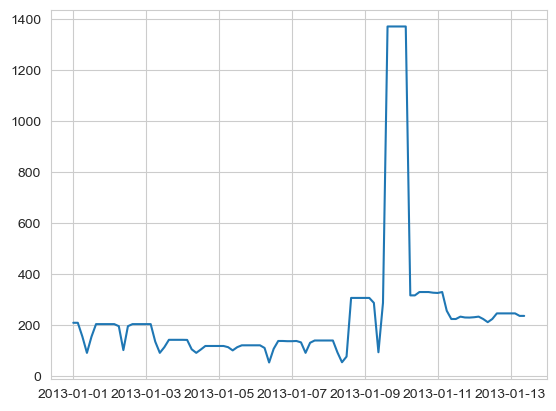

In [34]:
plt.plot(n.buses_t.marginal_price[["AL0 0"]][0:100])

In [35]:
# find snap with easy determination of marginal generator
n.generators_t.p

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,AT0 1 onwind,AT0 1 ror,AT0 1 solar,AT0 2 onwind,...,RS0 1 solar rooftop,SE3 0 solar rooftop,SE3 1 solar rooftop,SE3 2 solar rooftop,SE3 3 solar rooftop,SE3 5 solar rooftop,SE3 6 solar rooftop,SE3 7 solar rooftop,SI0 0 solar rooftop,SK0 0 solar rooftop
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,4917.113011,444.933907,0.000000,0.000160,102.555845,0.000000,0.000317,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,4623.535568,444.620944,0.000000,0.000105,102.483658,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,4795.128080,3455.948969,444.467881,792.324661,0.000061,102.448376,1207.124091,0.000000,...,365.072843,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,352.259879,523.284014
2013-01-01 09:00:00,0.000000,0.000000,11509.646090,1471.522842,444.478772,2989.259557,0.000000,102.450821,5691.630927,0.000000,...,1074.839751,1.210543,0.0,0.000619,0.035075,0.0,2.337271,0.0,1407.871519,1858.687944
2013-01-01 12:00:00,0.000000,0.000000,6377.253396,497.291894,447.815959,1678.141986,0.000000,103.219830,4162.664607,0.000000,...,577.275672,0.269088,0.0,0.000000,0.017729,0.0,0.533430,0.0,862.907142,875.497826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,4911.200758,448.489909,549.709582,1048.040739,0.000000,126.698785,4358.484623,0.000000,...,944.298303,0.260902,0.0,0.000000,0.150806,0.0,0.258412,0.0,130.935906,886.166876
2013-12-31 12:00:00,0.000000,0.000000,2989.734046,1290.876086,548.017655,710.217489,0.000000,126.316122,2908.464725,0.000000,...,407.896036,0.000000,0.0,0.000000,0.047555,0.0,0.000000,0.0,113.992430,544.052274
2013-12-31 15:00:00,0.000000,0.000000,0.000000,1932.721807,546.870825,0.000000,0.000000,126.052526,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [36]:
n.buses_t.marginal_price

Bus,AL0 0,AL0 0 EV battery,AL0 0 H2,AL0 0 H2 liquid,AL0 0 battery,AL0 0 home battery,AL0 0 low voltage,AL0 0 residential rural heat,AL0 0 residential rural water tanks,AL0 0 residential urban decentral heat,...,SK0 0 services rural water tanks,SK0 0 services urban decentral heat,SK0 0 services urban decentral water tanks,SK0 0 urban central heat,SK0 0 urban central water tanks,co2 atmosphere,co2 stored,gas for industry,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,208.089324,187.447538,132.306353,87210.617893,203.956540,207.193448,208.101095,56.974139,58.124200,98.687337,...,37.759799,125.280135,118.864605,118.047631,100.123259,-513.283465,-358.677321,113.318707,-414.293975,78.325642
2013-01-01 03:00:00,208.030183,187.447686,132.305622,132.315961,203.902052,205.714306,208.041610,57.018315,60.356861,231.005065,...,123.354232,131.588893,127.508619,119.289047,100.193499,-513.283465,-358.677360,113.334089,-412.864209,78.419905
2013-01-01 06:00:00,153.808216,187.447826,132.304178,132.314517,156.989409,169.934834,168.694456,185.978154,162.287216,187.391199,...,127.469042,131.586472,131.094079,119.372125,100.263177,-513.283465,-358.677378,113.349609,-412.188901,78.490917
2013-01-01 09:00:00,89.821566,182.553882,132.127980,132.138319,156.989293,167.097474,164.289516,45.035153,48.301899,125.271125,...,125.676186,125.283858,128.344296,119.430310,100.331808,-513.283465,-358.677391,113.365708,-411.875232,78.559337
2013-01-01 12:00:00,153.339481,182.554338,132.303825,132.314163,156.989346,167.635541,164.290191,45.045361,48.062406,125.255829,...,124.979069,125.281745,128.271108,119.428606,100.400904,-513.283465,-358.677399,113.395103,-411.642917,78.642735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,199.844657,187.446471,132.308110,132.318449,203.986154,201.531371,199.854464,56.431556,57.994492,79.089352,...,37.617372,125.278126,126.196737,118.054180,99.774169,-513.283465,-358.677308,112.957515,-407.839459,78.502628
2013-12-31 12:00:00,199.855407,187.446782,132.308083,132.318421,203.986169,202.085946,199.865679,56.451729,58.044303,77.418336,...,36.567638,125.275258,125.383352,118.052955,99.843746,-513.283465,-358.677296,112.949373,-407.825246,78.497642
2013-12-31 15:00:00,208.203744,187.447032,132.307921,132.318259,203.986319,206.444218,208.217403,58.830340,58.841772,125.150310,...,37.770381,125.276215,123.458995,118.054432,99.913423,-513.283465,-358.677267,112.944123,-407.815666,78.487410


In [37]:
n.generators.loc["AL0 0 solar"]

p_nom_max               53368.632501
weight                   2347.489775
p_nom                            0.0
capital_cost            48788.865309
carrier                        solar
marginal_cost                0.01938
efficiency                       1.0
p_nom_extendable                True
bus                            AL0 0
control                             
p_nom_opt                22582.11171
lifetime                         inf
type                                
p_nom_min                        0.0
p_min_pu                         0.0
p_max_pu                         1.0
p_set                            0.0
q_set                            0.0
sign                             1.0
build_year                         0
committable                    False
start_up_cost                    0.0
shut_down_cost                   0.0
min_up_time                        0
min_down_time                      0
up_time_before                     1
down_time_before                   0
r